                Location      Month  Predicted Prices
0   Halifax, Nova Scotia 2024-03-31             159.9
1   Halifax, Nova Scotia 2024-04-30             160.4
2   Halifax, Nova Scotia 2024-05-31             160.9
3   Halifax, Nova Scotia 2024-06-30             161.4
4   Halifax, Nova Scotia 2024-07-31             162.0
5   Halifax, Nova Scotia 2024-08-31             162.5
6   Halifax, Nova Scotia 2024-09-30             163.0
7   Halifax, Nova Scotia 2024-10-31             163.5
8   Halifax, Nova Scotia 2024-11-30             164.0
9   Halifax, Nova Scotia 2024-12-31             164.5
10  Halifax, Nova Scotia 2025-01-31             164.5
11  Halifax, Nova Scotia 2025-02-28             165.0
12  Halifax, Nova Scotia 2025-03-31             165.5
13  Halifax, Nova Scotia 2025-04-30             166.0
14  Halifax, Nova Scotia 2025-05-31             166.5
15  Halifax, Nova Scotia 2025-06-30             167.0
16  Halifax, Nova Scotia 2025-07-31             167.5
17  Halifax, Nova Scotia 202

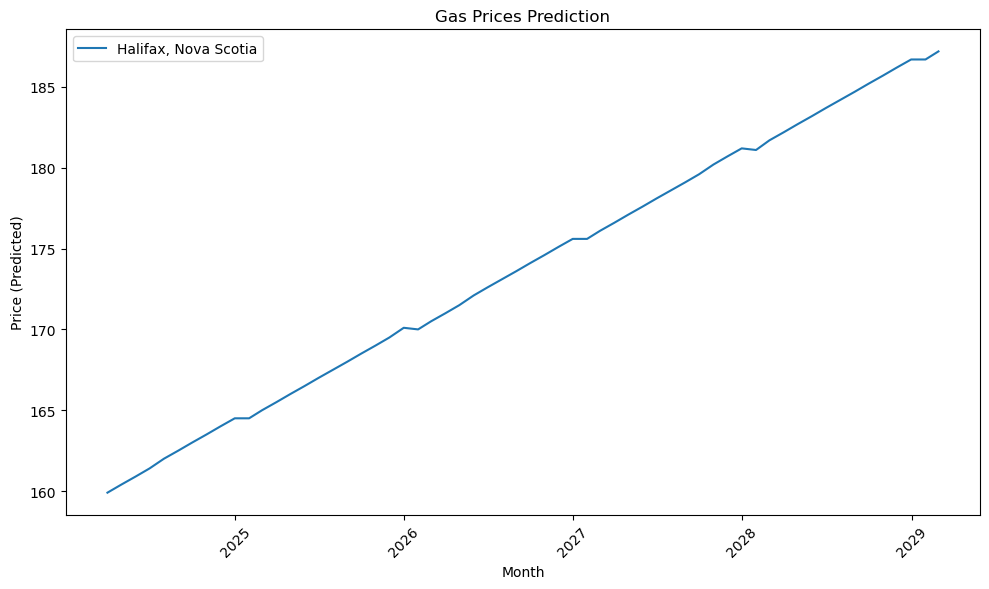

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load the data from gas.csv
df = pd.read_csv('Halifax.csv')

# Convert 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')

# Extract year and month as separate numerical features
df['Year'] = df['Month'].dt.year
df['Month_Num'] = df['Month'].dt.month

# Clean the data by removing rows with non-numeric values in 'Prices' column
df = df[pd.to_numeric(df['Prices'], errors='coerce').notnull()]

# Convert 'Prices' column to float
df['Prices'] = df['Prices'].astype(float)

# Filter data up until March 2024
df_filtered = df[df['Month'] <= '2024-03-01']

# Group the filtered data by 'Location' for predictions
groups = df_filtered.groupby('Location')

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through each group, train a linear regression model, and make predictions
for name, group in groups:
    # Get the last month's prices for this location
    last_month_prices = group.iloc[-1]['Prices']

    # Splitting the data into features (X) and target variable (y)
    X = group[['Year', 'Month_Num']]
    y = group['Prices']

    # Training a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Create a DataFrame for future dates for this location starting from March 2024
    start_date = pd.to_datetime('2024-03-01')
    future_dates = pd.date_range(start=start_date, periods=5 * 12, freq='M')
    future_df = pd.DataFrame({'Month': future_dates})
    future_df['Year'] = future_df['Month'].dt.year
    future_df['Month_Num'] = future_df['Month'].dt.month

    # Make predictions for this location starting from the March 2024 price
    future_predictions = model.predict(future_df[['Year', 'Month_Num']])

    # Add predictions to the list
    location_predictions_df = pd.DataFrame({
        'Location': [name] * len(future_dates),
        'Month': future_dates,
        'Predicted Prices': future_predictions.round(1)  # Round to one decimal place
    })
    dfs.append(location_predictions_df)

# Concatenate all DataFrames in the list
predictions_df = pd.concat(dfs, ignore_index=True)

# Save predictions to a CSV file
predictions_df.to_csv('predicted_Halifax_prices.csv', index=False)

# Display the predictions DataFrame
print(predictions_df)

# Evaluate model performance using R-squared
X_eval = df_filtered[['Year', 'Month_Num']]
y_eval = df_filtered['Prices']
y_pred_eval = model.predict(X_eval)
r_squared = r2_score(y_eval, y_pred_eval)
print(f"R-squared for model evaluation: {r_squared}")

# Plotting the predictions using Matplotlib
plt.figure(figsize=(10, 6))
for name, group in predictions_df.groupby('Location'):
    plt.plot(group['Month'], group['Predicted Prices'], label=name)

plt.xlabel('Month')
plt.ylabel('Price (Predicted)')
plt.title('Gas Prices Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('predicted_prices_plot.png')

# Show the plot
plt.show()
